In [1]:
import os
import sys
from copy import deepcopy

import torch
import matplotlib.pyplot as plt
from botorch.models.transforms.input import AffineInputTransform

from lume_model.variables import ScalarInputVariable, ScalarOutputVariable, InputVariable
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("calibration_modules/")
from calibration_modules.decoupled_linear import DecoupledLinearInput
from calibration_modules.utils import extract_input_transformer

In [2]:
# create base model
class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x) -> torch.Tensor:
        return x ** 2 + 0.3


base_model = BaseModel().double()

In [3]:
# create input transformers
input_sim_to_nn = AffineInputTransform(d=1, coefficient=torch.ones(1), offset=-0.5 * torch.ones(1))
input_pv_to_sim = AffineInputTransform(d=1, coefficient=torch.ones(1), offset=-0.5 * torch.ones(1))

# define in- and output variables
input_name, output_name = "InputPV", "OutputPV"
base_input_variables = {input_name: ScalarInputVariable(name=input_name, default=-1.0, value_range=[-2.0, 0.0])}
base_output_variables = {output_name: ScalarOutputVariable(name=output_name)}

# create LUME-model
base_model_file = "tmp.pt"
torch.save(base_model, base_model_file)
lume_model = PyTorchModel(
    model_file=base_model_file,
    input_variables=base_input_variables,
    output_variables=base_output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[],
)
os.remove(base_model_file)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)

In [4]:
# create miscalibrated base model
class MiscalibratedBaseModel(torch.nn.Module):
    def __init__(self, base_model, offset=0.3):
        super().__init__()
        self.base_model = base_model
        self.offset = offset

    def forward(self, x) -> torch.Tensor:
        x = x - self.offset
        mask = (-1.0 <= x) * (x <= 1.0)
        y = torch.zeros(x.shape, dtype=x.dtype)
        y[mask] = self.base_model(x[mask])
        y[~mask] = x[~mask] * 0.0
        return y


miscalibrated_base_model = MiscalibratedBaseModel(base_model).double()

In [5]:
# define in- and output variables
miscalibrated_input_variables = {k: v for k, v in base_input_variables.items()}
for k, v in base_input_variables.items():
    v.default += miscalibrated_base_model.offset
    v.value_range[0] += miscalibrated_base_model.offset
    v.value_range[1] += miscalibrated_base_model.offset
miscalibrated_output_variables = {k: v for k, v in base_output_variables.items()}

# create LUME-model
miscalibrated_base_model_file = "tmp.pt"
torch.save(miscalibrated_base_model, miscalibrated_base_model_file)
miscalibrated_lume_model = PyTorchModel(
    model_file=miscalibrated_base_model_file,
    input_variables=miscalibrated_input_variables,
    output_variables=miscalibrated_output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[],
)
os.remove(miscalibrated_base_model_file)

# wrap in LUMEModule
miscalibrated_lume_module = LUMEModule(
    model=miscalibrated_lume_model,
    feature_order=miscalibrated_lume_model.features,
    output_order=miscalibrated_lume_model.outputs,
)

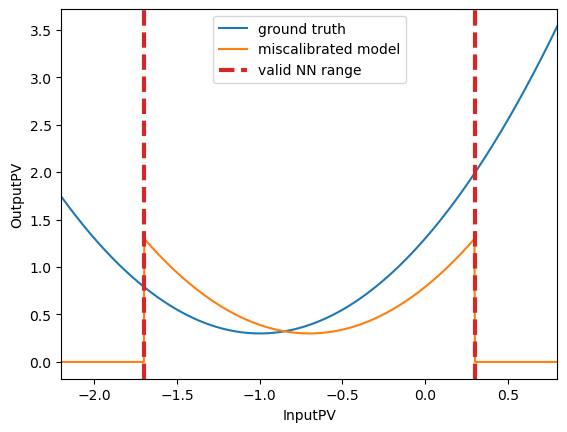

In [6]:
# compare on example data
x = torch.linspace(base_input_variables[input_name].value_range[0] - 0.5,
                   base_input_variables[input_name].value_range[1] + 0.5,
                   1000, dtype=torch.double).unsqueeze(-1)
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), "C0-", label="ground truth")
ax.plot(x, miscalibrated_lume_module(x), "C1-", label="miscalibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(x=miscalibrated_lume_model.input_variables[input_name].value_range[0], color="C3", linestyle="--", linewidth=3.0, 
           label="valid NN range")
ax.axvline(x=miscalibrated_lume_model.input_variables[input_name].value_range[1], color="C3", linestyle="--", linewidth=3.0)
ax.legend(loc="upper center");

In [7]:
# create training data set
x_train = torch.linspace(*miscalibrated_input_variables[input_name].value_range, 1000, dtype=torch.double).unsqueeze(-1)
with torch.no_grad():
    y_train = lume_module(x_train).unsqueeze(-1)

# normalize to NN units
for input_transformer in lume_model.input_transformers:
    x_train = input_transformer(x_train)

In [8]:
# create calibration model
cal_model = DecoupledLinearInput(
    model=miscalibrated_base_model,
    x_size=len(miscalibrated_lume_model.features),
)
cal_model

DecoupledLinearInput(
  (model): MiscalibratedBaseModel(
    (base_model): BaseModel()
  )
  (x_offset_prior): NormalPrior()
  (x_scale_prior): GammaPrior()
  (raw_x_scale_constraint): Positive()
)

In [9]:
# define trainable parameters
trainable_params = []
for name, param in cal_model.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params.append(getattr(cal_model, name))

raw_x_offset
raw_x_scale


In [10]:
# initial parameter values
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

x_offset:  tensor([0.])
x_scale:  tensor([1.])


## Train Calibration Layers

In [11]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [12]:
# define dataloader
batch_size = y_train.shape[0]
trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

In [13]:
# training configuration
reg = 1e-3
lr = 1e-3
n_epochs = int(5e3)
optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=reg)
criterion = torch.nn.L1Loss(reduction="sum")

In [14]:
%%time
# training loop
losses = []
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, targets = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i == 0:
            losses.append(loss.item())

CPU times: user 14.6 s, sys: 186 ms, total: 14.8 s
Wall time: 14.8 s


In [15]:
# parameter values after training
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

x_offset:  tensor([0.3002])
x_scale:  tensor([1.0001])


In [16]:
input_nn_to_cal = extract_input_transformer(cal_model)

In [17]:
# create LUME-model
miscalibrated_base_model_file = "tmp.pt"
torch.save(miscalibrated_base_model, miscalibrated_base_model_file)
calibrated_lume_model = PyTorchModel(
    model_file=miscalibrated_base_model_file,
    input_variables=miscalibrated_lume_model.input_variables,
    output_variables=miscalibrated_lume_model.output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    output_transformers=[],
)
os.remove(miscalibrated_base_model_file)

# wrap in LUMEModule
calibrated_lume_module = LUMEModule(
    model=calibrated_lume_model,
    feature_order=calibrated_lume_model.features,
    output_order=calibrated_lume_model.outputs,
)

## Training Results

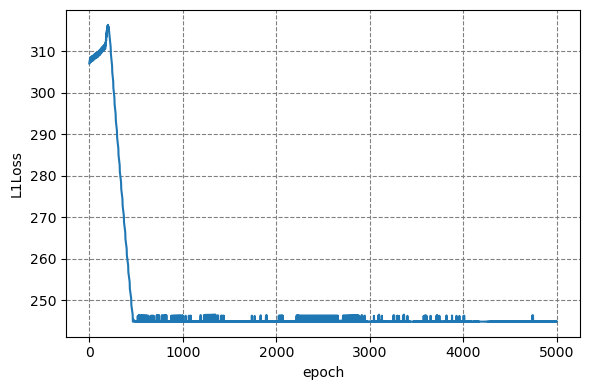

In [18]:
# plot training process
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("epoch")
ax.plot(losses, "C0")
ax.set_ylabel(criterion.__class__.__name__)
ax.grid(color="gray", linestyle="dashed")
# ax.set_yscale("log")
fig.tight_layout()

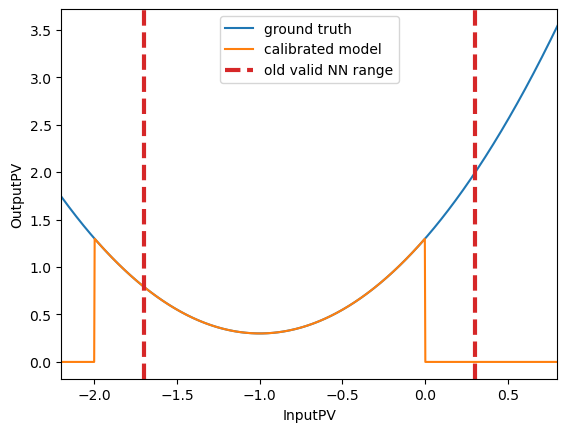

In [19]:
# compare on example data
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), label="ground truth")
ax.plot(x, calibrated_lume_module(x), label="calibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(x=miscalibrated_lume_model.input_variables[input_name].value_range[0], color="C3", linestyle="--", linewidth=3.0, 
           label="old valid NN range")
ax.axvline(x=miscalibrated_lume_model.input_variables[input_name].value_range[1], color="C3", linestyle="--", linewidth=3.0)
ax.legend(loc="upper center");

## Calculate New Valid NN Range

In [20]:
def update_input_variables_to_transformer(lume_model, transformer_loc: int) -> list[InputVariable]:
    """Returns input variables updated to the transformer at the given location.

    Updated are the value ranges and default of the input variables. This allows, e.g., to add a
    calibration transformer and to update the input variable specification accordingly.

    Args:
        lume_model: The LUME-model for which the input variables shall be updated.
        transformer_loc: The location of the input transformer to adjust for.

    Returns:
        The updated input variables.
    """
    x_old = {
        "min": torch.tensor([var.value_range[0] for var in lume_model.input_variables.values()], dtype=torch.double),
        "max": torch.tensor([var.value_range[1] for var in lume_model.input_variables.values()], dtype=torch.double),
        "default": torch.tensor([var.default for var in lume_model.input_variables.values()], dtype=torch.double),
    }
    x_new = {}
    for key in x_old.keys():
        x = x_old[key]
        # compute previous limits at transformer location
        for i in range(transformer_loc):
            x = lume_model.input_transformers[i].transform(x)
        # untransform of transformer to adjust for
        x = lume_model.input_transformers[transformer_loc].untransform(x)
        # backtrack through transformers
        for transformer in lume_model.input_transformers[:transformer_loc][::-1]:
            x = transformer.untransform(x)
        x_new[key] = x
    updated_variables = deepcopy(lume_model.input_variables)
    for i, var in enumerate(updated_variables.values()):
        var.value_range = [x_new["min"][i].item(), x_new["max"][i].item()]
        var.default = x_new["default"][i].item()
    return updated_variables

In [21]:
updated_input_variables = update_input_variables_to_transformer(calibrated_lume_model, transformer_loc=2)
calibrated_lume_model.input_variables = updated_input_variables

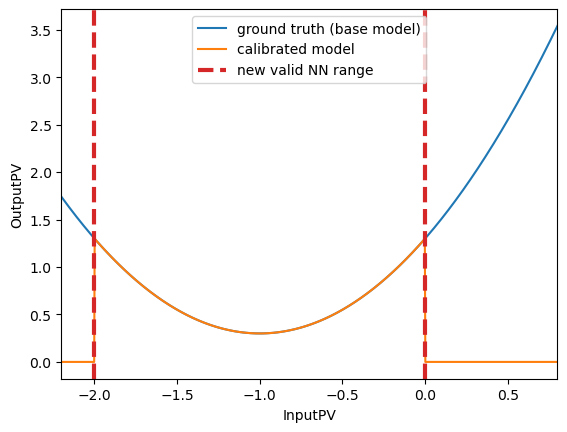

In [22]:
# compare on example data
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), label="ground truth (base model)")
ax.plot(x, calibrated_lume_module(x), label="calibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(x=calibrated_lume_model.input_variables[input_name].value_range[0], color="C3", linestyle="--", linewidth=3.0, 
           label="new valid NN range")
ax.axvline(x=calibrated_lume_model.input_variables[input_name].value_range[1], color="C3", linestyle="--", linewidth=3.0)
ax.legend(loc="upper center");

In [23]:
# more conservative range (we might exceed PV ranges)
min_conservative = max([miscalibrated_lume_model.input_variables[input_name].value_range[0],
                        calibrated_lume_model.input_variables[input_name].value_range[0]])
max_conservative = min([miscalibrated_lume_model.input_variables[input_name].value_range[1],
                        calibrated_lume_model.input_variables[input_name].value_range[1]])

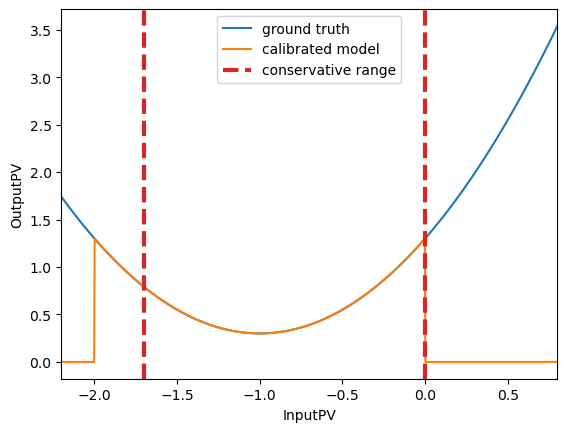

In [24]:
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), label="ground truth")
ax.plot(x, calibrated_lume_module(x), label="calibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(x=min_conservative, color="C3", linestyle="--", linewidth=3.0, label="conservative range")
ax.axvline(x=max_conservative, color="C3", linestyle="--", linewidth=3.0)
ax.legend(loc="upper center");